In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges, to_dense_adj, to_networkx
import sys
#add path to utils
sys.path.append('../../')
from utils import GraphDataset, reconstruct_matrix, GraphDatasetV3, gae_outputs_to_undirected_nx, _gt_tree_from_batch, _pred_tree_from_logits
from networks.graph_vae import GRAPH_VAE
from networks.graph_vae_v2 import GRAPH_VAE_V2
from networks.gae import GAE
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.utils.data import random_split
import argparse
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from torch_geometric.utils import negative_sampling
import itertools
import matplotlib.colors as mcolors
import random
from torch_geometric.utils.convert import from_networkx
from tqdm import tqdm

/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/lucas/graph_scenarios/venv/lib/python3.11/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: libcudart.so.11.0: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/

In [2]:
dataset = GraphDatasetV3(root='../../../data/sub20/graphs')

In [3]:
# Define the parameters
params = {
    'distribution_std': 0.1,
    'variational_beta': 0.05,
    'capacity': 1024,
    'dec_layers': 2,
    'enc_layers': 3,
    'ign_layers': 3,
    'ign_layers': 2,
}

In [4]:
input_dim = dataset.num_features
latent_dim = 128
model = GAE(input_dim, latent_dim, params, dataset.template).to("cuda")
# Load weights
model.load_state_dict(torch.load(f"../../networks/weights/VGAE_UNDIR_latent=128_lr=0.0002_epochs=1000_variational_beta=0.05_capacity=1024_dec_layers=2_enc_layers=3_ign_layers=2_edge_layers=2_best.pt")["model_state_dict"])

/tmp/ipykernel_62742/3147682886.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"../../networks/weights/VGAE_UNDIR_latent=128_lr=0.0002

<All keys matched successfully>

In [5]:
loader = DataLoader(dataset, batch_size=1, shuffle=True)
# Split the dataset into training, validation, and test sets
print("Splitting the dataset")
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
print(f"Train size: {train_size}, Val size: {val_size}")

# Seed split
SEED = 12345
g_split = torch.Generator().manual_seed(SEED)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=g_split)
device = torch.device('cuda')
model.to(device)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=4)

Splitting the dataset
Train size: 39300, Val size: 4912


In [6]:
def _micro_f1_on_edges(G_pred: nx.DiGraph, G_true: nx.DiGraph):
    """Micro-precision/recall/F1 over directed edges."""
    e_pred = set(G_pred.edges())
    e_true = set(G_true.edges())
    tp = len(e_pred & e_true)
    fp = len(e_pred - e_true)
    fn = len(e_true - e_pred)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1   = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0
    return tp, fp, fn, prec, rec, f1

@torch.no_grad()
def tune_tau_edge_for_tree_f1(
    model,
    loader,
    template,
    device,
    taus=None,                  # list of thresholds in prob space
    cache_outputs: bool = True, # cache model outputs to avoid recomputation per τ
    decode_fn=None,             # tree decoder (MST variant)
):
    """
    Grid-search τ_edge to maximize micro-F1 on reconstructed directed trees.

    decode_fn: callable(edge_logits_u, ign_logits, template, tau_edge) -> (G_pred, ign)
               defaults to _pred_tree_from_logits (weighted MST).

    Returns:
        best_tau: float
        metrics_by_tau: dict[tau] -> {"precision","recall","f1","tp","fp","fn","support_true","support_pred"}
    """
    model.eval()
    E_u = template.E_u
    N   = template.Nmax

    if decode_fn is None:
        decode_fn = _pred_tree_from_logits

    if taus is None:
        # Reasonable sweep in probability space
        taus = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45,
                0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]

    # ---- cache pass ----
    cached = []
    for batch in tqdm(loader):
        batch = batch.to(device)
        (edge_logits_u_B, ign_logits_B), mu, logvar = model(batch.x, batch.edge_index_enc, batch)
        # Shapes: [B, E_u], [B, N]
        B = edge_logits_u_B.size(0)

        # Pre-compute GT trees once
        for b in range(B):
            G_true = _gt_tree_from_batch(batch, template, b)
            cached.append({
                "edge_logits_u": edge_logits_u_B[b].detach().cpu(),  # [E_u]
                "ign_logits":    ign_logits_B[b].detach().cpu(),     # [N]
                "G_true":        G_true,
            })

    # ---- sweep taus ----
    best_tau = None
    best_f1  = -1.0
    metrics_by_tau = {}

    for tau in tqdm(taus):
        TP = FP = FN = 0
        for item in cached:
            G_pred, ign = decode_fn(item["edge_logits_u"], item["ign_logits"], template, tau_edge=tau)
            tp, fp, fn, prec, rec, f1 = _micro_f1_on_edges(G_pred, item["G_true"])
            TP += tp; FP += fp; FN += fn

        prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        rec  = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1   = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0

        metrics_by_tau[tau] = {
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "tp": TP, "fp": FP, "fn": FN,
            "support_true": TP + FN,
            "support_pred": TP + FP,
        }

        if f1 > best_f1:
            best_f1, best_tau = f1, tau

    return best_tau, metrics_by_tau


In [ ]:
# Create the DataLoader
best_tau, metrics_by_tau = tune_tau_edge_for_tree_f1(model, val_loader, dataset.template, device)

In [ ]:
best_tau

In [ ]:
metrics_by_tau

In [7]:
def plot_tau_edge_curve(metrics_by_tau, save_path=None, show=False, title="τ_edge sweep (MST tree F1)"):
    """
    Plot Precision/Recall/F1 vs τ_edge given the dict from tune_tau_edge_for_tree_f1.
    """
    taus = sorted(metrics_by_tau.keys())
    f1   = [metrics_by_tau[t]["f1"]        for t in taus]
    prec = [metrics_by_tau[t]["precision"] for t in taus]
    rec  = [metrics_by_tau[t]["recall"]    for t in taus]

    plt.figure()
    plt.plot(taus, f1,   marker="o", label="F1")
    plt.plot(taus, prec, marker="o", label="Precision")
    plt.plot(taus, rec,  marker="o", label="Recall")
    plt.xlabel("τ_edge (probability threshold)")
    plt.ylabel("Score")
    plt.title(title)
    plt.ylim(0.0, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    if show:
        plt.show()
    plt.close()

In [ ]:
plot_tau_edge_curve(metrics_by_tau, save_path="./Threshold_curve_GAE.png")

In [ ]:
model.eval()
device = torch.device('cpu')
model.to(device)
picked_G = None
for batch in loader:
    
    batch = batch.to(device)
    # use edge_index_enc if present; else fall back to edge_index
    edge_index_enc = getattr(batch, "edge_index_enc", batch.edge_index)
    output, mu, logvar = model(batch.x, edge_index_enc, batch)
    (edge_logits, ign_logits) = output

    # reconstruct NX graph from the model outputs
    G, ign = _pred_tree_from_logits(edge_logits_u=edge_logits.squeeze(0), ign_logits=ign_logits.squeeze(0), template=dataset.template, tau_edge=0.05)

    # replicate your “pick a mid-sized graph” filter (50 < #nodes < 60)
    if 30 < G.number_of_nodes() < 40:
        picked_G = G
        break


In [ ]:
if picked_G is None:
    # fall back to the last one
    picked_G = G

# position nodes by (col,row) or normalized positions
W = dataset.template.W
pos = {n: (n % W, -(n // W)) for n in picked_G.nodes}  # x=col, y=-row (flip y for nicer top-down look)
plt.figure(figsize=(6,6))
nx.draw(
    picked_G, pos,
    node_size=40,
    arrows=True,
    with_labels=False,
    cmap="viridis",
)
plt.tight_layout()
plt.show()

In [ ]:
# check number of connected components, turn into undirected graph
picked_G = G.to_undirected()
print(nx.number_connected_components(picked_G))


In [ ]:
# Ground-truth directed tree
G_real = _gt_tree_from_batch(batch, template=model.template, b = 0)

# Compare edges
edges_pred = set(picked_G.edges())
edges_real = set(G_real.edges())
unique_to_G = edges_pred - edges_real
unique_to_G_real = edges_real - edges_pred


In [ ]:
# draw graph
# drop unconnected nodes
G_real.remove_nodes_from(list(nx.isolates(G_real)))
pos = {n: (n % W, -(n // W)) for n in G_real.nodes}  # x=col, y=-row (flip y for nicer top-down look)

# draw with labels
nx.draw(G_real, pos,
    node_size=40,
    arrows=True,
    with_labels=False,
    cmap="viridis",)
plt.show()

In [ ]:
# Find connected components in the reconstructed graph
components = list(nx.weakly_connected_components(G))
colors = itertools.cycle(['#1f78b4', 'lightgreen', 'lightcoral', 'lightpink', 'lightyellow'])

# Assign a color to each node based on its component
node_colors = {}
for component, color in zip(components, colors):
    for node in component:
        node_colors[node] = color

# Plotting the graphs side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the reconstructed graph
pos = {n: (n % W, -(n // W)) for n in G.nodes} 
nx.draw(G, pos, ax=axes[0], with_labels=False, node_color=[node_colors[node] for node in G.nodes()], edge_color='gray', node_size=40)
if unique_to_G:
    nx.draw_networkx_edges(G, pos, edgelist=unique_to_G, edge_color='red', ax=axes[0])
axes[0].set_title('Reconstructed Graph')

# Plot the real graph
pos_real = {n: (n % W, -(n // W)) for n in G_real.nodes} 
G_real.remove_nodes_from(list(nx.isolates(G_real)))
nx.draw(G_real, pos_real, ax=axes[1], with_labels=False, node_color='green', edge_color='gray', node_size=40,)
if unique_to_G_real:
    nx.draw_networkx_edges(G_real, pos_real, edgelist=unique_to_G_real, edge_color='red', ax=axes[1])
axes[1].set_title('Real Graph')

plt.show()

In [ ]:
# Collect posterior samples
model.train()
_, mu, logvar = model(batch.x, edge_index_enc, batch)
edge_logits, ign_logits = output
G, ign = _pred_tree_from_logits(edge_logits_u=edge_logits.squeeze(0), ign_logits=ign_logits.squeeze(0), template=dataset.template, tau_edge=0.05)
num_samples = 3
samples = []
model.distribution_std = 0.5
for _ in range(num_samples):
    mu_ = model.latent_sample(mu, logvar)
    present_all = getattr(batch, "y_node_present", None)
    present_b    = (present_all == 1)             # [N]
    present_slots= present_b.nonzero(as_tuple=False).view(-1)  # [n_b]
    Z_full = model._scatter_to_full(mu_, present_slots, model.N)
    edge_logits = model._edge_logits_from_full(Z_full)
    ign_logits  = model.ign_head(Z_full).squeeze(-1)     
    Gs, ign = _pred_tree_from_logits(
        edge_logits_u=edge_logits.squeeze(0),
        ign_logits=ign_logits.squeeze(0),
        template=dataset.template, 
        tau_edge=0.05
    )
    samples.append(Gs)
model.distribution_std = 0.1

In [ ]:
# ---- Plot: GT + samples ----
cols = num_samples + 1
plt.figure(figsize=(3.0*cols, 3.2))
# GT
plt.subplot(1, cols, 1)
nx.draw(G, pos = {n: (n % W, -(n // W)) for n in G.nodes} , node_size=20, arrows=True, with_labels=False)
plt.title("Ground truth")

# Samples
for i, Gi in enumerate(samples, start=2):
    plt.subplot(1, cols, i)
    nx.draw(Gi, pos = {n: (n % W, -(n // W)) for n in Gi.nodes} , node_size=20, arrows=True, with_labels=False)
    plt.title(f"Sample {i-1}")
plt.tight_layout()
plt.show()


In [ ]:
import torch, random, networkx as nx
import matplotlib.pyplot as plt

@torch.no_grad()
def interpolate_two_graphs_and_plot(
    model,
    loader,
    template,
    n_steps: int = 6,          # number of interpolation snapshots between endpoints
    tau_edge: float = 0.0,     # edge cutoff before MST (0.0 = let MST handle)
    device=None,
):
    """
    Pick two graphs from a batch, interpolate *graph-level* latents z between them,
    broadcast z_t to present slots, get edge & ignition logits via model heads,
    decode to trees, and plot originals + interpolations.
    """
    device = device or next(model.parameters()).device
    model.eval().to(device)

    # --- get a batch with at least 2 graphs
    batch = None
    for b in loader:
        if b.num_graphs >= 2:
            batch = b
            break
    if batch is None:
        raise RuntimeError("Need a loader that yields batches with at least 2 graphs.")
    batch = batch.to(device)

    B = batch.num_graphs
    N = template.Nmax
    H, W = template.H, template.W

    # Prefer encoder edges if available
    edge_index_enc = getattr(batch, "edge_index_enc", batch.edge_index)

    # Run the model once to get (output, mu, logvar)
    # Your forward: output=(edge_logits_u, ign_logits) for the whole batch (GraphVAE-style),
    # but we will *ignore* edge_logits_u/ign_logits here and recompute from broadcast z_t as in your sampling snippet.
    output, mu, logvar = model(batch.x, edge_index_enc, batch)  # mu, logvar: [B, z]
    # Posterior std if you want stochastic endpoints (not used here, but trivial to add)
    # std = torch.exp(0.5 * logvar)

    # pick two distinct graph indices
    b1, b2 = random.sample(range(B), 2)
    z1 = mu[b1:b1+1]   # [1, z]
    z2 = mu[b2:b2+1]   # [1, z]

    # presence masks per graph (required to know which slots exist)
    present_all = getattr(batch, "y_node_present", None)
    if present_all is None:
        raise ValueError("batch.y_node_present is required.")
    present_all = present_all.view(B, N)

    present_slots_1 = (present_all[b1] == 1).nonzero(as_tuple=False).view(-1)  # [n1]
    present_slots_2 = (present_all[b2] == 1).nonzero(as_tuple=False).view(-1)  # [n2]
    # union of supports so we can visualize interpolations on a stable support
    present_union = torch.unique(torch.cat([present_slots_1, present_slots_2], dim=0))

    # helpers that mirror your sampling code
    def z_to_full(z_row, present_slots):
        """
        Broadcast a single graph-level latent z_row: [1, d] to a full [N, d],
        writing the same z into the rows for present slots; zeros elsewhere.
        """
        d = z_row.size(-1)
        Z_full = z_row.new_zeros(N, d)
        Z_full[present_slots] = z_row.expand(present_slots.numel(), d)
        return Z_full

    # choose ignition head name
    ign_head = getattr(model, "ign_head", None)
    if ign_head is None:
        ign_head = getattr(model, "ignition_head", None)
    if ign_head is None:
        raise AttributeError("Model must expose ign_head or ignition_head for ignition logits.")

    # Ground-truth directed trees for endpoints (for the side plots)
    G1_true = _gt_tree_from_batch(batch, template, b=b1)
    G2_true = _gt_tree_from_batch(batch, template, b=b2)

    # Interpolate between z1 and z2
    ts = torch.linspace(0., 1., steps=n_steps, device=device)
    interp_graphs = []
    for t in ts:
        zt = (1.0 - float(t)) * z1 + float(t) * z2                # [1, z]
        Z_full = z_to_full(zt, present_union)                     # [N, z]
        edge_logits_u = model._edge_logits_from_full(Z_full)      # [E_u]
        ign_logits    = ign_head(Z_full).squeeze(-1)              # [N]

        Gt, _ = _pred_tree_from_logits(
            edge_logits_u=edge_logits_u,
            ign_logits=ign_logits,
            template=template,
            tau_edge=tau_edge
        )
        interp_graphs.append((float(t.item()), Gt))

    # --- plotting ---
    def pos(G):  # grid layout
        return {n: (n % W, -(n // W)) for n in G.nodes()}

    cols = n_steps + 2  # endpoints + interpolations
    plt.figure(figsize=(3.0 * cols, 3.2))

    # left: original A
    plt.subplot(1, cols, 1)
    nx.draw(G1_true, pos=pos(G1_true), node_size=20, arrows=True, with_labels=False)
    plt.title("Original A")

    # middle: interpolations
    for i, (tval, Gi) in enumerate(interp_graphs, start=2):
        plt.subplot(1, cols, i)
        nx.draw(Gi, pos=pos(Gi), node_size=20, arrows=True, with_labels=False)
        plt.title(f"t={tval:.2f}")

    # right: original B
    plt.subplot(1, cols, cols)
    nx.draw(G2_true, pos=pos(G2_true), node_size=20, arrows=True, with_labels=False)
    plt.title("Original B")

    plt.tight_layout()
    plt.show()


In [ ]:
loader_ = DataLoader(dataset, batch_size=2, shuffle=True)
interpolate_two_graphs_and_plot(model, loader_, template=dataset.template, n_steps=6, tau_edge=0.05, device=device)

In [8]:
import torch, networkx as nx
from tqdm import tqdm

# ---------- helper: MST with uniform edge weights (weight=1) ----------
@torch.no_grad()
def _pred_tree_uniform_mst_from_logits(
    edge_logits_u,        # [E_u] tensor (logits for feasible undirected pairs)
    ign_logits,           # [N]   tensor (ignition logits over slots)
    template,             # has .undir_src, .undir_dst, .H, .W, .Nmax
    tau_edge: float = 0.5
):
    """
    1) Threshold undirected edge probs (sigmoid >= tau_edge).
    2) Build an undirected graph with all kept edges weight=1.
    3) Restrict to the component containing the predicted ignition.
    4) Compute an MST (all weights equal).
    5) Orient edges away from ignition (directed arborescence).
    """
    p_u = torch.sigmoid(edge_logits_u).detach().cpu()  # [E_u]
    keep = (p_u >= tau_edge).nonzero(as_tuple=False).view(-1)

    # Undirected candidate pairs
    s_all = template.undir_src
    t_all = template.undir_dst
    if torch.is_tensor(s_all):
        s_all = s_all.cpu().tolist()
        t_all = t_all.cpu().tolist()

    # Build undirected graph with kept edges (uniform weights)
    G_u = nx.Graph()
    N = int(template.Nmax)
    G_u.add_nodes_from(range(N))
    for idx in keep.tolist():
        s, t = int(s_all[idx]), int(t_all[idx])
        if s != t:
            G_u.add_edge(s, t, weight=1.0)

    # Predicted ignition (top-1)
    ign = int(torch.argmax(ign_logits).item())

    # Restrict to component containing ignition
    if ign in G_u and G_u.number_of_nodes() > 0 and G_u.degree(ign) > 0:
        comp_nodes = nx.node_connected_component(G_u, ign)
        G_u = G_u.subgraph(comp_nodes).copy()
    else:
        G_trivial = nx.DiGraph()
        G_trivial.add_node(ign)
        return G_trivial, ign

    # Maximum spanning tree with uniform weights
    T_u = nx.maximum_spanning_tree(G_u, weight="weight")

    # Orient via BFS from ignition
    return nx.bfs_tree(T_u, source=ign), ign


def _pred_tree_from_logits_by_mst_mode(
    edge_logits_u,
    ign_logits,
    template,
    tau_edge: float,
    mst_mode: str,
):
    if mst_mode == "weighted":
        return _pred_tree_from_logits(edge_logits_u, ign_logits, template, tau_edge=tau_edge)
    if mst_mode == "uniform":
        return _pred_tree_uniform_mst_from_logits(edge_logits_u, ign_logits, template, tau_edge=tau_edge)
    raise ValueError(f"Unknown mst_mode: {mst_mode}")


In [9]:
best_tau_weighted, metrics_by_tau_weighted = tune_tau_edge_for_tree_f1(
    model, val_loader, dataset.template, device, decode_fn=_pred_tree_from_logits
)
best_tau_uniform, metrics_by_tau_uniform = tune_tau_edge_for_tree_f1(
    model, val_loader, dataset.template, device, decode_fn=_pred_tree_uniform_mst_from_logits
)


100%|██████████| 18/18 [04:10<00:00, 13.89s/it]


In [10]:
best_tau_weighted, best_tau_uniform


(0.05, 0.4)

In [12]:
plot_tau_edge_curve(
    metrics_by_tau_weighted,
    save_path="./Threshold_curve_weighted_mst_GAE.png",
    title="τ_edge sweep (weighted MST tree F1)",
)
plot_tau_edge_curve(
    metrics_by_tau_uniform,
    save_path="./Threshold_curve_uniform_mst_GAE.png",
    title="τ_edge sweep (uniform MST tree F1)",
)


In [13]:
def extract_curves_and_best(metrics_by_tau):
    taus = sorted(metrics_by_tau.keys())
    prec = [metrics_by_tau[t]["precision"] for t in taus]
    rec  = [metrics_by_tau[t]["recall"]    for t in taus]
    f1   = [metrics_by_tau[t]["f1"]        for t in taus]

    # best by F1
    best_idx = int(np.argmax(f1))
    best = {
        "tau": taus[best_idx],
        "precision": prec[best_idx],
        "recall": rec[best_idx],
        "f1": f1[best_idx],
    }
    return taus, prec, rec, f1, best


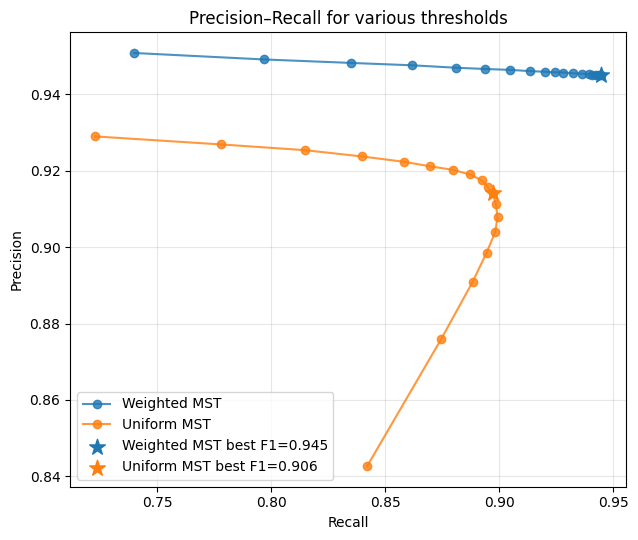

In [14]:
import matplotlib.pyplot as plt
import numpy as np

taus_w, prec_w, rec_w, f1_w, best_w = extract_curves_and_best(metrics_by_tau_weighted)
taus_u, prec_u, rec_u, f1_u, best_u = extract_curves_and_best(metrics_by_tau_uniform)

plt.figure(figsize=(6.5, 5.5))

# curves
plt.plot(rec_w, prec_w, "o-", label="Weighted MST", alpha=0.8)
plt.plot(rec_u, prec_u, "o-", label="Uniform MST", alpha=0.8)

# stars at best F1
plt.scatter(
    best_w["recall"], best_w["precision"],
    s=140, marker="*", zorder=5,
    label=f"Weighted MST best F1={best_w['f1']:.3f}"
)
plt.scatter(
    best_u["recall"], best_u["precision"],
    s=140, marker="*", zorder=5,
    label=f"Uniform MST best F1={best_u['f1']:.3f}"
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall for various thresholds")
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("post_1_gae.png")


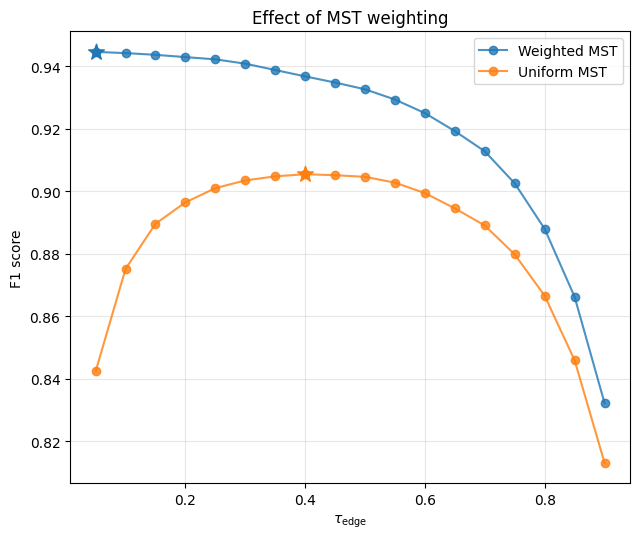

In [15]:
plt.figure(figsize=(6.5, 5.5))

plt.plot(taus_w, f1_w, "o-", label="Weighted MST", alpha=0.8)
plt.plot(taus_u, f1_u, "o-", label="Uniform MST", alpha=0.8)

# stars at best τ
plt.scatter(
    best_w["tau"], best_w["f1"],
    s=140, marker="*", zorder=5
)
plt.scatter(
    best_u["tau"], best_u["f1"],
    s=140, marker="*", zorder=5
)

plt.xlabel(r"$\tau_{\mathrm{edge}}$")
plt.ylabel("F1 score")
plt.title("Effect of MST weighting")
plt.legend(frameon=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("post_2_gae.png")


In [16]:
def confusion_counts(G_pred: nx.DiGraph, G_true: nx.DiGraph):
    e_pred = set(G_pred.edges())
    e_true = set(G_true.edges())

    tp = len(e_pred & e_true)
    fp = len(e_pred - e_true)
    fn = len(e_true - e_pred)

    # TN is not well-defined over "all possible edges",
    # but for accuracy we define:
    # acc = TP / |E_true|   (tree setting)
    return tp, fp, fn


In [17]:
@torch.no_grad()
def collect_graph_metrics(
    model,
    loader,
    template,
    device,
    tau_edge: float,
    mst_mode: str,
):
    model.eval()
    metrics = []

    for batch in loader:
        batch = batch.to(device)
        (edge_logits_u_B, ign_logits_B), _, _ = model(
            batch.x, batch.edge_index_enc, batch
        )
        B = edge_logits_u_B.size(0)

        for b in range(B):
            G_true = _gt_tree_from_batch(batch, template, b=b)
            G_pred, _ = _pred_tree_from_logits_by_mst_mode(
                edge_logits_u=edge_logits_u_B[b],
                ign_logits=ign_logits_B[b],
                template=template,
                tau_edge=tau_edge,
                mst_mode=mst_mode,
            )

            tp, fp, fn = confusion_counts(G_pred, G_true)
            denom_true = max(1, len(G_true.edges()))

            prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
            rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
            f1   = (2 * prec * rec) / (prec + rec) if (prec + rec) > 0 else 0.0
            acc  = tp / denom_true

            metrics.append({
                "precision": prec,
                "recall": rec,
                "f1": f1,
                "accuracy": acc,
            })

    return metrics


In [18]:
import numpy as np

def bootstrap_ci(values, n_boot=2000, ci=95):
    vals = np.asarray(values)
    boots = []
    n = len(vals)

    for _ in range(n_boot):
        sample = np.random.choice(vals, size=n, replace=True)
        boots.append(sample.mean())

    lo = np.percentile(boots, (100 - ci) / 2)
    hi = np.percentile(boots, 100 - (100 - ci) / 2)
    return vals.mean(), lo, hi


In [19]:
def mst_metrics_with_ci(
    model,
    loader,
    template,
    device,
    tau_edge,
    n_boot=2000,
    mst_mode: str = "weighted",
):
    metrics = collect_graph_metrics(
        model, loader, template, device, tau_edge, mst_mode=mst_mode
    )

    out = {}
    for k in ["precision", "recall", "f1", "accuracy"]:
        mean, lo, hi = bootstrap_ci([m[k] for m in metrics], n_boot=n_boot)
        out[k] = {
            "mean": mean,
            "ci_low": lo,
            "ci_high": hi,
        }
    return out


In [20]:
best_tau = best_tau_weighted  # from tune_tau_edge_for_tree_f1

ci_results = mst_metrics_with_ci(
    model=model,
    loader=test_loader,
    template=model.template,
    device=device,
    tau_edge=best_tau,
    mst_mode="weighted",
)

for k, v in ci_results.items():
    print(
        f"{k:10s}: {v['mean']:.3f} "
        f"[{v['ci_low']:.3f}, {v['ci_high']:.3f}]"
    )


precision : 0.952 [0.951, 0.953]
recall    : 0.951 [0.950, 0.952]
f1        : 0.951 [0.950, 0.953]
accuracy  : 0.951 [0.950, 0.952]


In [21]:
best_tau = best_tau_uniform  # from tune_tau_edge_for_tree_f1

ci_results = mst_metrics_with_ci(
    model=model,
    loader=test_loader,
    template=model.template,
    device=device,
    tau_edge=best_tau,
    mst_mode="uniform",
)

for k, v in ci_results.items():
    print(
        f"{k:10s}: {v['mean']:.3f} "
        f"[{v['ci_low']:.3f}, {v['ci_high']:.3f}]"
    )


precision : 0.923 [0.921, 0.925]
recall    : 0.902 [0.899, 0.905]
f1        : 0.909 [0.907, 0.912]
accuracy  : 0.902 [0.899, 0.905]


In [ ]:
best_tau = best_tau_weighted  # from tune_tau_edge_for_tree_f1

ci_results = mst_metrics_with_ci(
    model=model,
    loader=test_loader,
    template=model.template,
    device=device,
    tau_edge=best_tau,
    mst_mode="weighted",
)

for k, v in ci_results.items():
    print(
        f"{k:10s}: {v['mean']:.3f} "
        f"[{v['ci_low']:.3f}, {v['ci_high']:.3f}]"
    )


precision : 0.952 [0.951, 0.953]
recall    : 0.951 [0.950, 0.952]
f1        : 0.951 [0.950, 0.953]
accuracy  : 0.951 [0.950, 0.952]


In [ ]:
best_tau = best_tau_weighted  # from tune_tau_edge_for_tree_f1

ci_results = mst_metrics_with_ci(
    model=model,
    loader=test_loader,
    template=model.template,
    device=device,
    tau_edge=best_tau,
    mst_mode="weighted",
)

for k, v in ci_results.items():
    print(
        f"{k:10s}: {v['mean']:.3f} "
        f"[{v['ci_low']:.3f}, {v['ci_high']:.3f}]"
    )


precision : 0.952 [0.951, 0.953]
recall    : 0.951 [0.950, 0.952]
f1        : 0.951 [0.950, 0.953]
accuracy  : 0.951 [0.950, 0.952]


In [ ]:
best_tau = best_tau_weighted  # from tune_tau_edge_for_tree_f1

ci_results = mst_metrics_with_ci(
    model=model,
    loader=test_loader,
    template=model.template,
    device=device,
    tau_edge=best_tau,
    mst_mode="weighted",
)

for k, v in ci_results.items():
    print(
        f"{k:10s}: {v['mean']:.3f} "
        f"[{v['ci_low']:.3f}, {v['ci_high']:.3f}]"
    )


precision : 0.952 [0.951, 0.953]
recall    : 0.951 [0.950, 0.952]
f1        : 0.951 [0.950, 0.953]
accuracy  : 0.951 [0.950, 0.952]
